# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [1]:
from google.colab import files
uploaded = files.upload()

Saving videos.zip to videos.zip


In [2]:
import zipfile
import io

# Replace 'your_uploaded_file.zip' with the name of your uploaded file
with zipfile.ZipFile(io.BytesIO(uploaded['videos.zip']), 'r') as zip_ref:
    zip_ref.extractall('/content/videos')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [4]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components=2, tol=1e-3, max_iter=100, reg_covar=1e-6):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.reg_covar = reg_covar
        self.weights = None
        self.means = None
        self.covariances = None

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights = np.full(self.n_components, 1 / self.n_components)
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)]) + self.reg_covar

    def e_step(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            rv = multivariate_normal(mean=self.means[k], cov=self.covariances[k])
            responsibilities[:, k] = self.weights[k] * rv.pdf(X)
        responsibilities_sum = responsibilities.sum(axis=1)[:, np.newaxis]
        responsibilities /= responsibilities_sum
        return responsibilities

    def m_step(self, X, responsibilities):
        n_samples, n_features = X.shape
        for k in range(self.n_components):
            responsibility = responsibilities[:, k]
            total_responsibility = responsibility.sum()
            self.means[k] = (X * responsibility[:, np.newaxis]).sum(axis=0) / total_responsibility
            diff = X - self.means[k]
            self.covariances[k] = np.dot(responsibility * diff.T, diff) / total_responsibility + self.reg_covar * np.eye(n_features)
            self.weights[k] = total_responsibility / n_samples

    def fit(self, X):
        self.initialize_parameters(X)
        for _ in range(self.max_iter):
            responsibilities = self.e_step(X)
            self.m_step(X, responsibilities)

    def predict(self, X):
        responsibilities = self.e_step(X)
        return np.argmax(responsibilities, axis=1)


### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [5]:
source_folder = './videos/videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [6]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [7]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [8]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [9]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [10]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

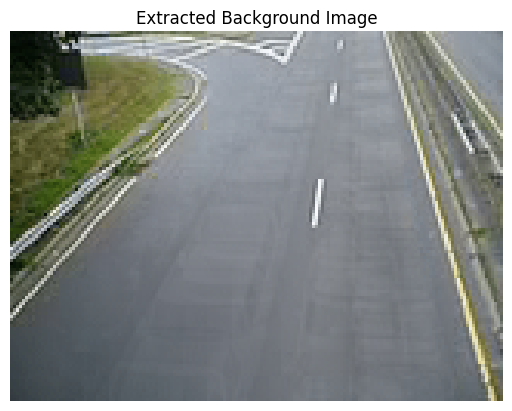

In [11]:
def extract_background_from_frames(frames):
    background = np.mean(frames, axis=0)
    return background

# Extract the background image from the training frames
background_image = extract_background_from_frames(train_frames)

# Display the background image
plt.imshow(background_image)
plt.title('Extracted Background Image')
plt.axis('off')  # Hide axis
plt.show()

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [13]:
n_train_frames ,n_width, n_height,n_channels = train_frames.shape
background_image_gmm = np.zeros((n_width,n_height,n_channels))

# Fitting the GMM model on every single pixel of all the frames

for i in range(n_width):
  for j in range(n_height):
    # for k in range(n_channels):
      gmm_extract_bg =GMM(n_components=2, tol=1e-3, max_iter=100)
      new_test_frame = train_frames[:,i,j]
      gmm_extract_bg.fit(new_test_frame)
      idx = np.argmax(gmm_extract_bg.weights)
      background_image_gmm[i][j] = gmm_extract_bg.means[idx]

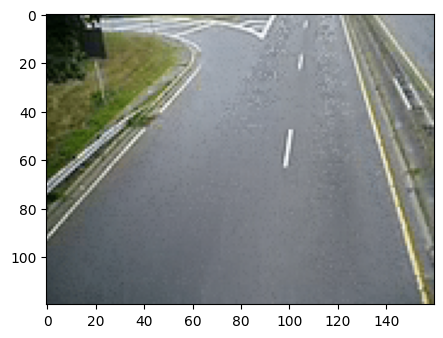

In [14]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, interpolation=None, save=False, save_name=None):
    eps = 0.0001

    img = img.astype(np.float64)
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + eps)

    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    fig.tight_layout()

    if interpolation != None:
        plt.imshow(img, interpolation = interpolation)
    else:
        plt.imshow(img)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('off')

    if save:
        if save_name is None:
            save_name = title

        # plt.imsave(f'../imgs/{save_name}.png', img)
        plt.savefig(f'../results/{save_name}.png', bbox_inches='tight')

    plt.show()
    plt.close(fig)
# Visualzing the background image extracted through gmm
plot_rgb(background_image_gmm, figsize=(5, 5))

#### Extract Background Image from the trained model

### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [15]:
# helper functions

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break

    cv2.destroyAllWindows()

from google.colab.patches import cv2_imshow

def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)  # Use cv2_imshow instead of cv2.imshow
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

        vid_wrt.write(frame)

    vid_wrt.release()
    cv2.destroyAllWindows()

In [16]:
import matplotlib.pyplot as plt

def remove_background_frames(background_image_method):
    result_frames = []
    for i in range(test_frames.shape[0]):
        foregrounds = np.abs(test_frames[i] - background_image_method)
        foregrounds = np.array(foregrounds)
        plt.figure(figsize=(4, 3))
        plt.imshow(foregrounds, cmap='gray')
        plt.axis('off')
        plt.show()
        result_frames.append(foregrounds)
    return result_frames

#### Frame Averaging

In [17]:
from google.colab.patches import cv2_imshow

In [ ]:
# your output here
bg_removed_frame_averaging=remove_background_frames(background_image_method=background_image)

In [ ]:
save_frames(bg_removed_frame_averaging, file_name='background_image_frames')

#### GMMs per pixel

In [ ]:
# your output here
bg_removed_frame_averaging=remove_background_frames(background_image_method=background_image_gmm)

In [ ]:
save_frames(bg_removed_frame_averaging, file_name='background_image_gmm_frames')